## Adaptive data retrieval demo

In [2]:
from app.dataprocessing.data_handler import DataHandler
from app.dataprocessing.benchmark import Timer, Plot, get_file_size_MB
from dotenv import load_dotenv
import os
import numpy as np


### Example 1: Copernicus dataset with 3 dimensions accessed via OPeNDAP

The OPeNDAP protocol provides subsetting of data on-demand, and initially only provides meta-data about the data.
This meta-data is enough to generate the different data structures

European Ocean- Sea Surface Temperature L4 analysis

source: https://resources.marine.copernicus.eu/product-detail/SST_EUR_PHY_L4_NRT_010_031/DATA-ACCESS

In [20]:
"""
Copernicus uses CAS SSO for authentication.
user credentials are saved in .env file.
"""

load_dotenv()
USERNAME = os.environ.get("CMEMS_CAS_USERNAME")
PASSWORD = os.environ.get("CMEMS_CAS_PASSWORD")

cas_url = "https://cmems-cas.cls.fr/cas/login"

dataset_url = "https://nrt.cmems-du.eu/thredds/dodsC/METEOFRANCE-EUR-SST-L4-NRT-OBS_FULL_TIME_SERIE"


##### Create DataHandler instance, this class will later be directly mapped to the API endpoints

Datastructure is automatically selected based on number of dimensions in the dataset

In [21]:
# Create a DataHandler object, one instance per dataset is required
data_handler = DataHandler()

# Establish connection to the remote data source

# Note: The OPeNDAP access class will estimate the total file size by downloanding a small slice of the dataset.
# This will take some time, and therefore file size of the dataset should be provided as parameter if known
data_handler.set_opendap_cas(cas_url, dataset_url, USERNAME, PASSWORD)

# Set the maximum chunk size in MB.
# keep in mind that the client can possibly work with multiple chunks simoultaneously to increase interactivity. This is a design choice front-end.
data_handler.set_max_chunk_size(50)

# Show the auto-selected data structure
print(f"Data structure in use: {data_handler.data_structure}")


Data structure in use: Octree with 4096 chunks of maximum size 50MB


##### Display meta data

In [22]:
print(f"data set total size: {data_handler.data_source.file_size_MB} MB")
print(data_handler.ds)


data set total size: 27817 MB
<xarray.Dataset>
Dimensions:           (lat: 2500, lon: 4750, time: 409)
Coordinates:
  * lat               (lat) float32 20.01 20.03 20.05 ... 69.95 69.97 69.99
  * lon               (lon) float32 -39.99 -39.97 -39.95 ... 54.95 54.97 54.99
  * time              (time) datetime64[ns] 2020-11-18 2020-11-19 ... 2022-01-01
Data variables:
    analysed_sst      (time, lat, lon) float32 ...
    analysis_error    (time, lat, lon) float32 ...
    sea_ice_fraction  (time, lat, lon) float32 ...
    mask              (time, lat, lon) float32 ...
Attributes: (12/50)
    title:                      Euro SST, L4, 0.02deg daily, MeteoFrance
    myocean_id:                 SST_EUR_SST_L4_NRT_OBSERVATIONS_010_009_c
    summary:                    A merged, multi-sensor L4 subskin SST product...
    processing_level:           L4
    product_id:                 SST_EUR_L4_NRT_OBSERVATIONS_010_018
    Conventions:                CF-1.4
    ...                         ...
  

##### Request the inital dataset and render

Finished 'Get inital dataset from server' in 77.2948 seconds
File size: 38.67 MB


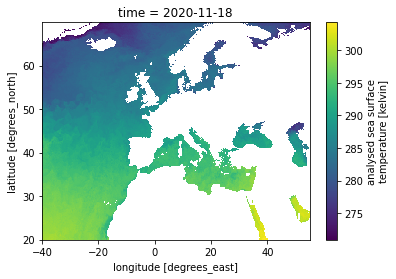

In [23]:
with Timer("Get inital dataset from server"):
    file_name = data_handler.get_inital_netcdf()
print(f"File size: {get_file_size_MB(file_name):.2f} MB")

Plot.netcdf_color_contour(data_variable="analysed_sst", netcdf_file=file_name)


##### The initial dataset equals the "root" chunk in the data structure. After requesting it from the server it is cached locally. The next request for this particular chunk will take advantage of the cache.

Finished 'Get inital dataset from local cache' in 0.3853 seconds
File size: 38.67 MB


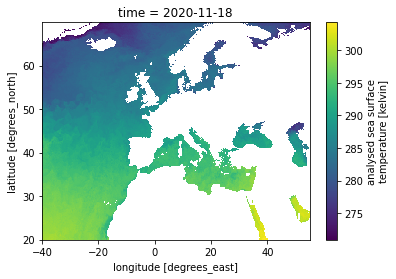

In [24]:
with Timer("Get inital dataset from local cache"):
    file_name = data_handler.get_inital_netcdf()
print(f"File size: {get_file_size_MB(file_name):.2f} MB")

Plot.netcdf_color_contour(data_variable="analysed_sst", netcdf_file=file_name)


##### Next step is to query area of interest e.g. area between The British Isles and Greenland 2020-11-18

Observe that the server will fetch the best fitting chunk to the bounds and time range requested. In the case below it will return a larger time range than necessary. This is due to the nature of how the dataset is split. There may exist a more sophisticated way of splitting the data into chunks

Finished 'Fetch the chunk covering the area between The British Isles and Greenland' in 30.2282 seconds
File size: 27.90 MB
Dimensions of current chunk Frozen({'lat': 250, 'lon': 475, 'time': 41})


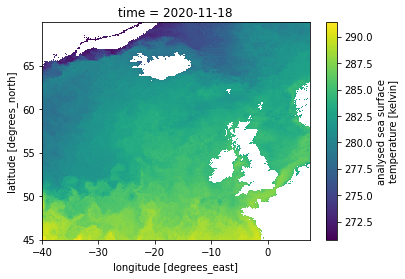

In [25]:
query_bounds = (
    (45, 69),
    (-39, 7),
    (np.datetime64("2020-11-18"), np.datetime64("2020-11-19")),
)

with Timer("Fetch the chunk covering the area between The British Isles and Greenland"):
    file_name, xr_chunk = data_handler.request_data_netcdf(
        query_bounds, return_xr_chunk=True
    )
print(f"File size: {get_file_size_MB(file_name):.2f} MB")
print(f"Dimensions of current chunk {xr_chunk.ds.dims}")

Plot.netcdf_color_contour(data_variable="analysed_sst", netcdf_file=file_name)


##### The client will zoom into an area of interest. This could for example be the sea area between ireland and britain

Finished 'Fetch the chunk covering the sea area between ireland and britain' in 30.5679 seconds
File size: 16.14 MB
Dimensions of current chunk Frozen({'lat': 209, 'lon': 396, 'time': 34})


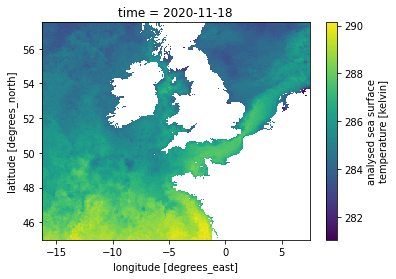

In [26]:
query_bounds = (
    (53.236217, 55.009163),
    (-6.471515, -3.173936),
    (np.datetime64("2020-11-18"), np.datetime64("2020-12-19")),
)

with Timer("Fetch the chunk covering the sea area between ireland and britain"):
    file_name, xr_chunk = data_handler.request_data_netcdf(
        query_bounds, return_xr_chunk=True
    )
print(f"File size: {get_file_size_MB(file_name):.2f} MB")
print(f"Dimensions of current chunk {xr_chunk.ds.dims}")

Plot.netcdf_color_contour(data_variable="analysed_sst", netcdf_file=file_name)


##### Due to the chunk structure we receive data outside the requested time range. This may increase interacivity for future requests in nearby, spatial or temporal, locations

In [27]:
print(xr_chunk.ds["time"])


<xarray.DataArray 'time' (time: 34)>
array(['2020-11-18T00:00:00.000000000', '2020-11-21T00:00:00.000000000',
       '2020-11-24T00:00:00.000000000', '2020-11-27T00:00:00.000000000',
       '2020-11-30T00:00:00.000000000', '2020-12-03T00:00:00.000000000',
       '2020-12-06T00:00:00.000000000', '2020-12-09T00:00:00.000000000',
       '2020-12-12T00:00:00.000000000', '2020-12-15T00:00:00.000000000',
       '2020-12-18T00:00:00.000000000', '2020-12-21T00:00:00.000000000',
       '2020-12-24T00:00:00.000000000', '2020-12-27T00:00:00.000000000',
       '2020-12-30T00:00:00.000000000', '2021-01-02T00:00:00.000000000',
       '2021-01-05T00:00:00.000000000', '2021-01-08T00:00:00.000000000',
       '2021-01-11T00:00:00.000000000', '2021-01-14T00:00:00.000000000',
       '2021-01-17T00:00:00.000000000', '2021-01-20T00:00:00.000000000',
       '2021-01-23T00:00:00.000000000', '2021-01-26T00:00:00.000000000',
       '2021-01-29T00:00:00.000000000', '2021-02-01T00:00:00.000000000',
       '2021-0

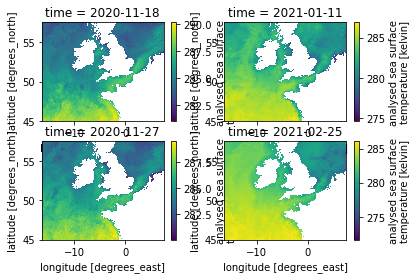

In [28]:
# select some random cached timestamps
time = [
    np.datetime64("2020-11-18"),
    np.datetime64("2021-01-11"),
    np.datetime64("2020-11-27"),
    np.datetime64("2021-02-25"),
]

Plot.netcdf_color_contour_multi_time(
    data_variable="analysed_sst", time=time, netcdf_file=file_name
)


##### The above plot shows the complete lat,lon range of the returned chunk. It is possible to slice the dataset to fit the requested at the cost of extra processing:

Finished 'Fetch the chunk covering the sea area between ireland and britain' in 0.0580 seconds
File size: 0.04 MB


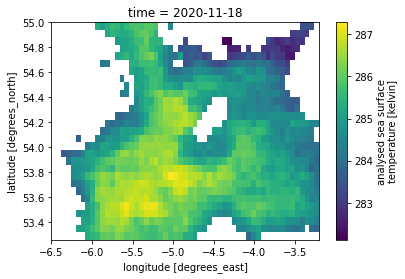

In [29]:
query_bounds = (
    (53.236217, 55.009163),
    (-6.471515, -3.173936),
    (np.datetime64("2020-11-18"), np.datetime64("2020-11-19")),
)

with Timer("Fetch the chunk covering the sea area between ireland and britain"):
    file_name, xr_chunk = data_handler.request_data_netcdf(
        query_bounds, return_xr_chunk=True, fit_bounds=True
    )
print(f"File size: {get_file_size_MB(file_name):.2f} MB")

Plot.netcdf_color_contour(data_variable="analysed_sst", netcdf_file=file_name)


##### Here is the data at full resolution at requested bounds, directly fetched from Copernicus

Observation: We can se that this is at a higher resolution than what the Octree can provide. This is due to the fact that the chunks include the time axis which uses a lot of the point_budget AND that the area in interest overlaps two chunks in the higher res layer below.

Possible solutions:
- Assume that the client can handle e.g. 4 chunks instead of 1
- split the data in a way that favors large x,y range and small z range or vice versa
- Set the max_chunk_size after the dataset meta-data is known, either manual or by some algorithms
- create the sparse dataset in passes to get closer to the chunk_size_limit

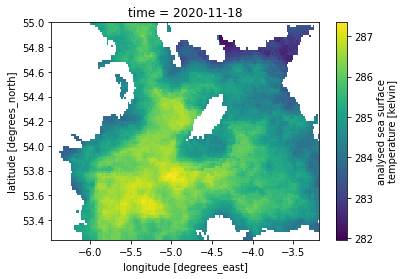

In [30]:
import xarray as xr

sub = data_handler.ds.sel(
    lat=slice(53.236217, 55.009163),
    lon=slice(-6.471515, -3.173936),
    time=slice(np.datetime64("2020-11-18"), np.datetime64("2020-11-19")),
)
sub.to_netcdf("orig_d.nc")

Plot.netcdf_color_contour(data_variable="analysed_sst", netcdf_file="orig_d.nc")


### Example 2: QuadTree on 7,5GB local dataset

GEBCO’s Gridded Bathymetry Data

Source: https://www.gebco.net/data_and_products/gridded_bathymetry_data/

In [26]:
data_handler = DataHandler()
data_handler.set_max_chunk_size(50)

file_path = "app/externalresources/datasets/GEBCO_2021.nc"

with Timer("Read data from local file and create Quadtree"):
    data_handler.set_local_netcdf_reader(file_path)


print(f"Data structure in use: {data_handler.data_structure}")

Data structure in use: QuadTree with 256 chunks at lowest level of max chunk size 50


##### Display meta data

In [27]:
print(f"data set total size: {data_handler.data_source.file_size_MB} MB")
print(data_handler.ds)

data set total size: 7120.149932861328 MB
<xarray.Dataset>
Dimensions:    (lon: 86400, lat: 43200)
Coordinates:
  * lon        (lon) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * lat        (lat) float64 -90.0 -89.99 -89.99 -89.99 ... 89.99 89.99 90.0
Data variables:
    crs        |S1 ...
    elevation  (lat, lon) int16 ...
Attributes: (12/36)
    title:                           The GEBCO_2021 Grid - a continuous terra...
    summary:                         The GEBCO_2021 Grid is a continuous, glo...
    keywords:                        BATHYMETRY/SEAFLOOR TOPOGRAPHY, DIGITAL ...
    Conventions:                     CF-1.6, ACDD-1.3
    id:                              DOI: 10.5285/c6612cbe-50b3-0cff-e053-6c8...
    naming_authority:                https://dx.doi.org
    ...                              ...
    geospatial_vertical_units:       meters
    geospatial_vertical_resolution:  1.0
    geospatial_vertical_positive:    up
    identifier_product_doi:          

##### Requst inital dataset and render

Finished 'Generate inital dataset' in 3.8241 seconds
File size: 49.55 MB


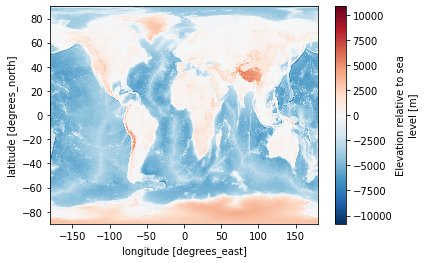

In [28]:
with Timer("Generate inital dataset"):
    file_name = data_handler.get_inital_netcdf()
print(f"File size: {get_file_size_MB(file_name):.2f} MB")

Plot.netcdf_color_contour(data_variable="elevation", netcdf_file=file_name)


### Example 3: KDTree on 5,46GB local dataset

Baltic Sea Physics Reanalysis (SUBSET, time index 0-30)

Source: https://resources.marine.copernicus.eu/product-detail/BALTICSEA_REANALYSIS_PHY_003_011/INFORMATION

In [40]:
data_handler = DataHandler()
data_handler.set_max_chunk_size(50)

file_path = "app/externalresources/datasets/BALTICSEA_REANALYSIS_PHY_003_011_slice.nc"

custom_rule = [("time", 10)]
data_handler.set_custom_rules(custom_rule)

data_handler.set_local_netcdf_reader(file_path)


print(f"Data structure in use: {data_handler.data_structure}")


Data structure in use: KDTree with 128 leaf nodes of maximum size 50MB


##### Display meta data

In [41]:
print(f"data set total size: {data_handler.data_source.file_size_MB} MB")
print(data_handler.ds)

data set total size: 5203.675380706787 MB
<xarray.Dataset>
Dimensions:    (depth: 56, latitude: 523, longitude: 383, time: 30)
Coordinates:
  * depth      (depth) float32 1.501 4.513 7.54 10.58 ... 666.8 688.9 711.1
  * latitude   (latitude) float32 48.49 48.53 48.56 48.59 ... 65.82 65.86 65.89
  * longitude  (longitude) float32 9.014 9.069 9.125 9.18 ... 30.12 30.18 30.24
  * time       (time) datetime64[ns] 1993-01-01T12:00:00 ... 1993-01-30T12:00:00
Data variables:
    sob        (time, latitude, longitude) float32 ...
    bottomT    (time, latitude, longitude) float32 ...
    mlotst     (time, latitude, longitude) float32 ...
    so         (time, depth, latitude, longitude) float32 ...
    thetao     (time, depth, latitude, longitude) float32 ...
    uo         (time, depth, latitude, longitude) float32 ...
    vo         (time, depth, latitude, longitude) float32 ...
Attributes: (12/23)
    references:             http://www.smhi.se
    institution:            Swedish Meterologic

##### Request the inital dataset and render Salinity at surface

Finished 'Generate inital dataset' in 0.5725 seconds
File size: 22.67 MB


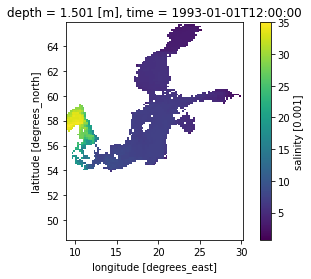

In [42]:
with Timer("Generate inital dataset"):
    file_name = data_handler.get_inital_netcdf()
print(f"File size: {get_file_size_MB(file_name):.2f} MB")

Plot.netcdf_color_contour(data_variable="so", netcdf_file=file_name, aspect_ratio=1.5)


Last render is quite low resolution because it covers the complete spatio and temporal range (and only a fraction is actually rendered)

##### Requst the data present in the last render

Finished 'Fetch the node representing the data on 1993-01-01' in 0.4182 seconds
File size: 20.28 MB


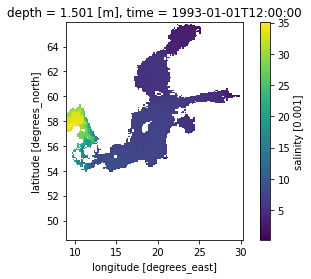

In [51]:
bounds = {
    "latitude": (0, 90),
    "longitude": (0, 90),
    "time": (np.datetime64("1993-01-01"), np.datetime64("1993-01-01")),
    "depth": (1.501, 4.513),
}

with Timer("Fetch the node representing the data on 1993-01-01"):
    file_name, xr_chunk = data_handler.request_data_netcdf(bounds, return_xr_chunk=True)
print(f"File size: {get_file_size_MB(file_name):.2f} MB")

Plot.netcdf_color_contour(data_variable="so", netcdf_file=file_name, aspect_ratio=1.5)


##### Query the south-west area

Finished 'Fetch the node covering the south-west corner of the Baltic Sea' in 0.3452 seconds
File size: 5.59 MB
Dimensions of current chunk Frozen({'depth': 28, 'latitude': 66, 'longitude': 48, 'time': 4})


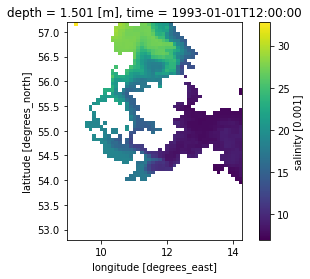

In [50]:
bounds = {'latitude': (54,56), 'longitude': (9.1, 14), 'time': (np.datetime64('1993-01-01'), np.datetime64('1993-01-01'))}

with Timer("Fetch the node covering the south-west corner of the Baltic Sea"):
    file_name, xr_chunk = data_handler.request_data_netcdf(
        bounds, return_xr_chunk=True
    )
print(f"File size: {get_file_size_MB(file_name):.2f} MB")
print(f"Dimensions of current chunk {xr_chunk.ds.dims}")

Plot.netcdf_color_contour(data_variable="so", netcdf_file=file_name, aspect_ratio=1.5)